In [1]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\Ashwin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:

class DatasetProcessor:
    def __init__(self, name):
        self.df = pd.read_csv(name).fillna(0)

    def calculate_innings_stats(self):
        self.df["innings_total"] = self.df.groupby(["match_id", "innings"])["runs_off_bat"].transform(lambda x : x.shift().fillna(0).cumsum()) + self.df.groupby(["match_id", "innings"])["extras"].transform(lambda x : x.shift().fillna(0).cumsum())
        self.df["wicket"] = (self.df["wicket_type"] != 0).astype(int)
        self.df["innings_wickets"] = self.df.groupby(["match_id", "innings"])["wicket"].transform(lambda x : x.shift().fillna(0).cumsum())
        
        self.df["ball"] = self.df["ball"].astype(int) * 6 + (self.df["ball"] - self.df["ball"].astype(int)) * 10
        self.df["over"] = self.df["ball"] // 6
        self.df["outcome"] = self.df.apply(lambda ball : 7 if ball["wicket"] == 1 else ball["runs_off_bat"], axis=1)

    def calculate_striker_stats(self):
        self.df["striker_runs"] = self.df.groupby(["match_id", "striker"])["runs_off_bat"].transform(lambda x : x.shift().fillna(0).cumsum())
        self.df["striker_balls"] = self.df.groupby(["match_id", "striker"])["runs_off_bat"].transform("cumcount")

    def calculate_bowler_stats(self):
        self.df["bowler_runs"] = self.df.groupby(["match_id", "bowler"])["runs_off_bat"].transform(lambda x : x.shift().fillna(0).cumsum())
        self.df["bowler_balls"] = self.df.groupby(["match_id", "bowler"])["runs_off_bat"].transform("cumcount")
        self.df["bowler_wickets"] = self.df.groupby(["match_id", "bowler"])["wicket"].transform(lambda x : x.shift().fillna(0).cumsum())

    def select_season(self, season):
        self.df = self.df[self.df.season == season]

    def process(self):
        self.select_season(2023)
        self.calculate_innings_stats()
        self.calculate_striker_stats()
        self.calculate_bowler_stats()
        self.df = self.df[self.df.outcome != 5]

        return self.df[["season", 
                        "venue", 
                        "innings", 
                        "innings_total",
                        "innings_wickets",
                        "ball", 
                        "over",
                        "striker",
                        "striker_runs", 
                        "striker_balls",
                        "bowler",
                        "bowler_runs",
                        "bowler_balls",
                        "bowler_wickets", 
                        "runs_off_bat",
                        "outcome"]]

In [4]:
class ExpectedModel:
    def __init__(self, dataset):
        self.dataset = dataset

    def train(self):
        X = ["innings_total",
             "innings_wickets",
             "over", 
             "striker_runs", 
             "striker_balls",
             "bowler_runs",
             "bowler_balls",
             "bowler_wickets"]
        
        Y = "outcome"

        pipeline = make_pipeline(StandardScaler(),
                                 MLPClassifier())
        
        dummies = self.dataset[Y]
        X_train, X_test, y_train, y_test = train_test_split(self.dataset[X], dummies, test_size=0.3)
        pipeline.fit(X_train, y_train)

        return pipeline

In [5]:
p = DatasetProcessor("IPL_ball_by_ball_updated.csv")
df = p.process()
trainer = ExpectedModel(df)

In [6]:
df

,season,venue,innings,innings_total,innings_wickets,ball,over,striker,striker_runs,striker_balls,bowler,bowler_runs,bowler_balls,bowler_wickets,runs_off_bat,outcome
225953,2023,"Narendra Modi Stadium, Ahmedabad",1,0.0,0.0,1.0,0.0,DP Conway,0.0,0,Mohammed Shami,0.0,0,0.0,0,0
225954,2023,"Narendra Modi Stadium, Ahmedabad",1,0.0,0.0,2.0,0.0,DP Conway,0.0,1,Mohammed Shami,0.0,1,0.0,0,0
225955,2023,"Narendra Modi Stadium, Ahmedabad",1,1.0,0.0,3.0,0.0,RD Gaikwad,0.0,0,Mohammed Shami,0.0,2,0.0,0,0
225956,2023,"Narendra Modi Stadium, Ahmedabad",1,1.0,0.0,4.0,0.0,RD Gaikwad,0.0,1,Mohammed Shami,0.0,3,0.0,1,1
225957,2023,"Narendra Modi Stadium, Ahmedabad",1,2.0,0.0,5.0,0.0,DP Conway,0.0,2,Mohammed Shami,1.0,4,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243810,2023,"Narendra Modi Stadium, Ahmedabad",2,158.0,5.0,86.0,14.0,S Dube,30.0,19,MM Sharma,23.0,13,3.0,1,1
243811,2023,"Narendra Modi Stadium, Ahmedabad",2,159.0,5.0,87.0,14.0,RA Jadeja,4.0,3,MM Sharma,24.0,14,3.0,1,1
243812,2023,"Narendra Modi Stadium, Ahmedabad",2,160.0,5.0,88.0,14.0,S Dube,31.0,20,MM Sharma,25.0,15,3.0,1,1
243813,2023,"Narendra Modi Stadium, Ahmedabad",2,161.0,5.0,89.0,14.0,RA Jadeja,5.0,4,MM Sharma,26.0,16,3.0,6,6


In [7]:
model = trainer.train()

C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
X = ["innings_total",
             "innings_wickets",
             "over", 
             "striker_runs", 
             "striker_balls",
             "bowler_runs",
             "bowler_balls",
             "bowler_wickets"]

xR = (model.predict_proba(df[X]) * np.array([[0, 1, 2, 3, 4, 6, 0]])).sum(axis=1)
df["preds"] = xR

C:\Users\Ashwin\AppData\Local\Temp\ipykernel_7736\3710995195.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["preds"] = xR


C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='ball', ylabel='runs_off_bat'>

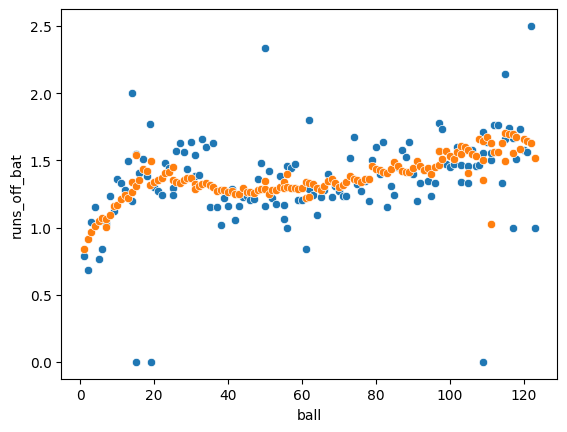

In [9]:
ball_group = df.groupby("ball", as_index=False).agg({ "runs_off_bat": "mean", "preds": "mean" })
sns.scatterplot(data=ball_group, x="ball", y="runs_off_bat")
sns.scatterplot(data=ball_group, x="ball", y="preds")

C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='striker_runs', ylabel='runs_off_bat'>

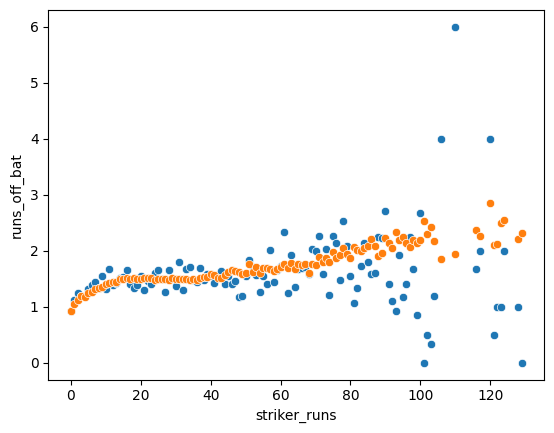

In [10]:
runs_group = df.groupby("striker_runs", as_index=False).agg({ "runs_off_bat": "mean", "preds": "mean" })
sns.scatterplot(data=runs_group, x="striker_runs", y="runs_off_bat")
sns.scatterplot(data=runs_group, x="striker_runs", y="preds")

C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Ashwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='innings_total', ylabel='runs_off_bat'>

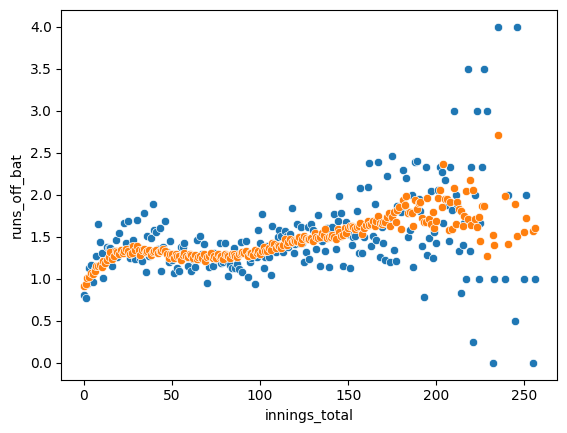

In [11]:
total_group = df.groupby("innings_total", as_index=False).agg({ "runs_off_bat": "mean", "preds": "mean" })
sns.scatterplot(data=total_group, x="innings_total", y="runs_off_bat")
sns.scatterplot(data=total_group, x="innings_total", y="preds")

In [12]:
import pickle
file = open("model.pkl", "wb")
pickle.dump(model, file)